In [9]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [10]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_class, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_class", "lang_path"))
lang_class = class_from_package("language", lang_class)
lang = lang_class.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: -0.902990261968926, node: PEPTIDE1{A.A.K.R.Q.R.R.R.[dK].[dR].P.G}$$$$
1- time: 0.04, count_rollouts: 2, reward: 0.5008098294939669, node: PEPTIDE1{A.V.A.P}$$$$
2- time: 0.09, count_rollouts: 4, reward: -0.8703598553302436, node: PEPTIDE1{R.V.I.E.V.W.Y.S.M.R}$$$$
3- time: 0.11, count_rollouts: 5, reward: -0.6260881038397621, node: PEPTIDE1{Y.[dW].[dW].D.F.[am]}$$$$
4- time: 0.17, count_rollouts: 7, reward: -0.8821564712626871, node: PEPTIDE1{F.P.R.K.E.E.E.K.H}$$$$
5- time: 0.22, count_rollouts: 9, reward: -0.9144508140742837, node: PEPTIDE1{T.P.Q.R.R.R.R.R.K.K.R.G}$$$$
6- time: 0.25, count_rollouts: 10, reward: -0.8399600717349857, node: PEPTIDE1{K.T.F.G.F.L.A.R}$$$$
7- time: 0.27, count_rollouts: 11, reward: 0.9243982687597833, node: PEPTIDE1{L.V.R.R.R.R.R.A}$$$$
8- time: 0.29, count_rollouts: 12, reward: -0.7743502887286452, node: PEPTIDE1{L.L.A.P.R.Y.I}$$$$
9- time: 0.42, count_rollouts: 15, reward: -0.9067178765318946, nod

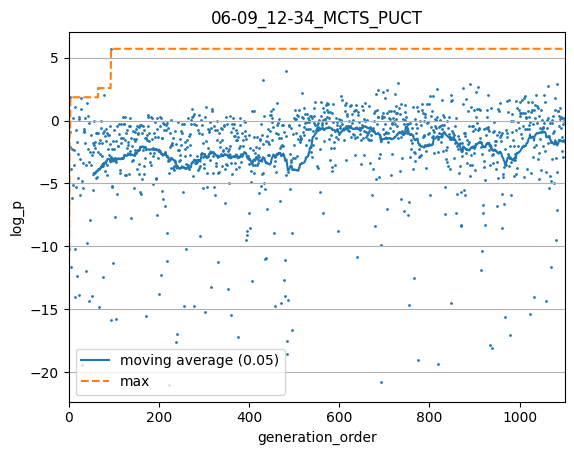

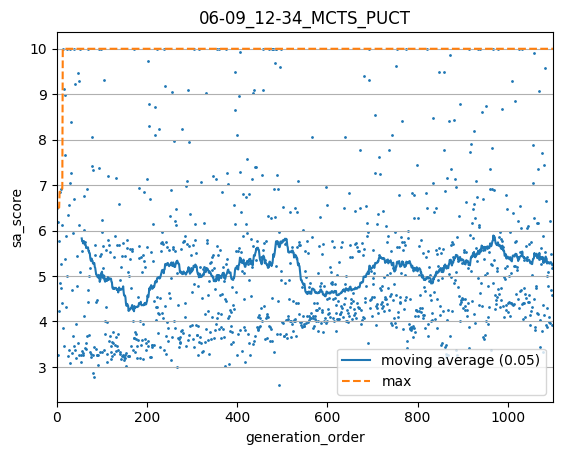

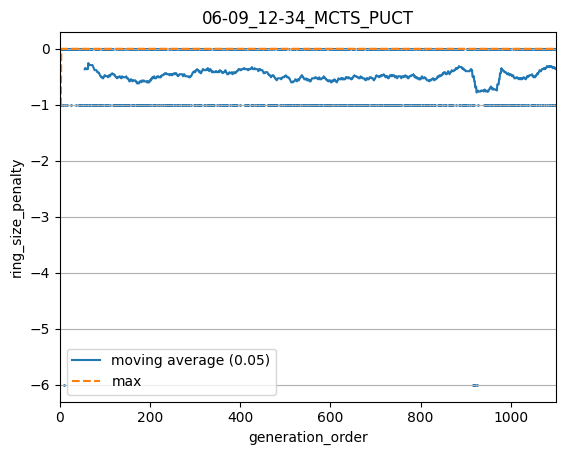

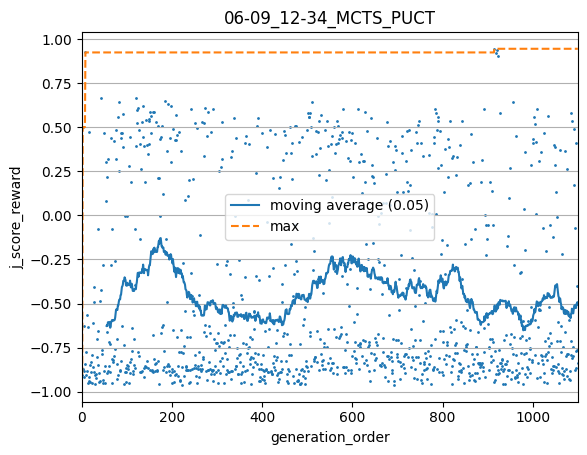

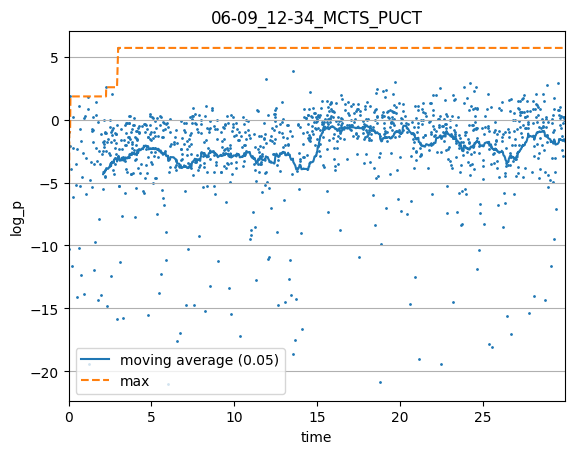

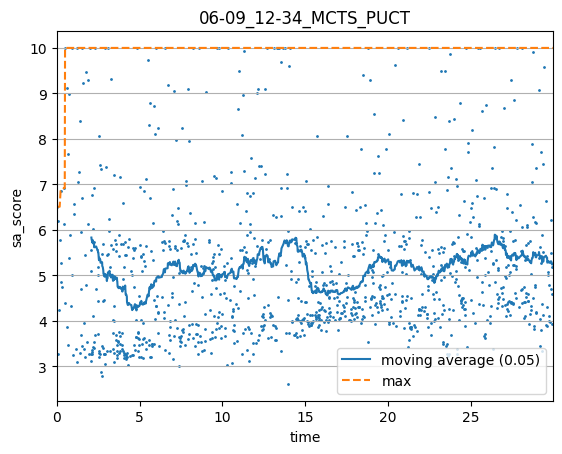

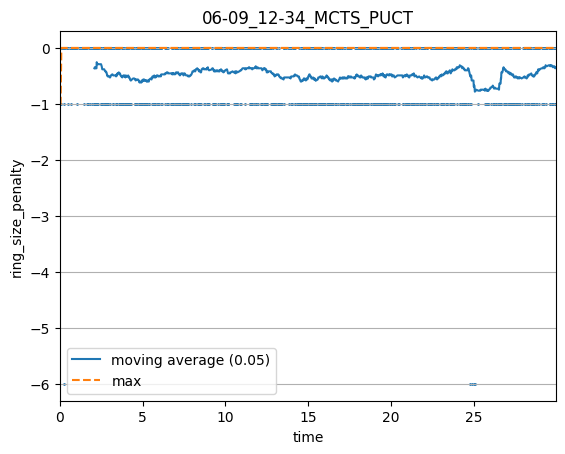

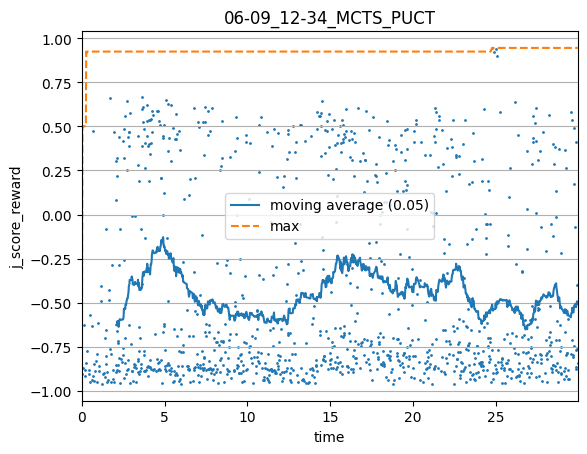

In [12]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)